Инициализируем импорты и тест Дики-Фуллера

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Загрузим данные по месячным продажам и подберем лучшие значения авторегресси, интеграции и скользящего среднего для модели ARIMA

In [2]:
sales_of_company_x = pd.read_csv("./monthly-sales-of-company-x-jan-6.csv")
X = sales_of_company_x["Count"]

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(X, order=(i,d,j)).fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 851.14756 | order: (4, 2, 4)


Проверим модель с лучшими гиперпараметрами на стационарность

Results of Dickey-Fuller Test:
Test Statistic                 -1.772680
p-value                         0.394107
#Lags Used                     11.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


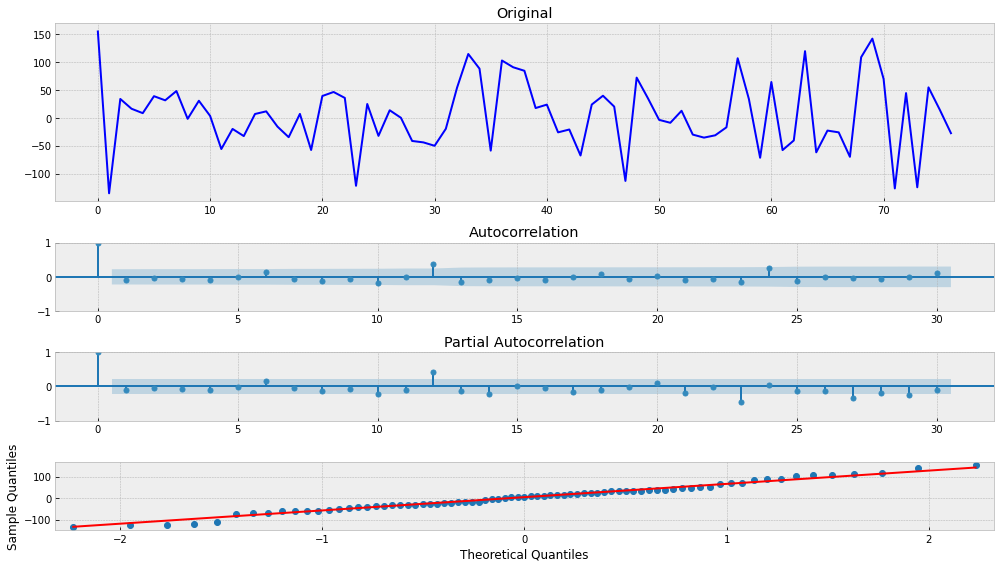

In [3]:
tsplot(best_mdl.resid, lags=30)

Построим график сравнения реальных значений и предсказанных, с продолжением ряда предсказания на 20 временных ед.

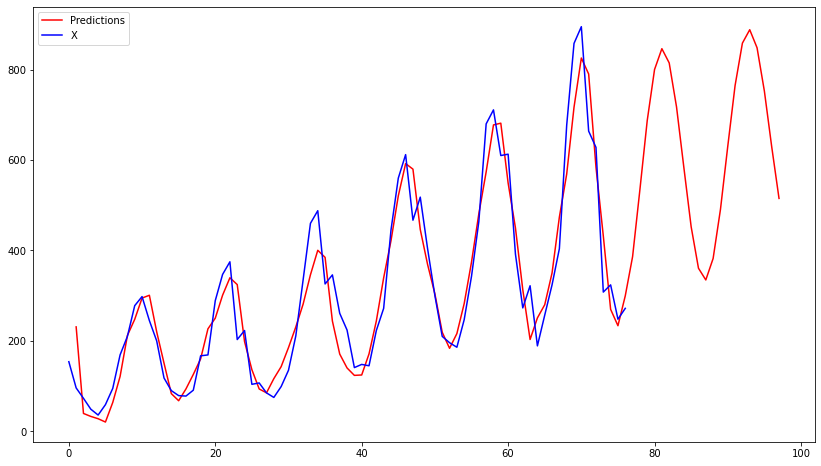

In [4]:
plt.figure(figsize=(14,8))
ax = plt.axes()
predictions = best_mdl.predict(1, len(X)+20, ax=ax)
plt.plot(predictions, color='red', label='Predictions')
plt.plot(X, color='blue', label='X')
plt.legend()
plt.show()